In [ ]:
# From SAV to LOVE

# HW 6

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/covid19-ct-scans/metadata.csv
/kaggle/input/covid19-ct-scans/lung_mask/radiopaedia_4_85506_1.nii
/kaggle/input/covid19-ct-scans/lung_mask/radiopaedia_29_86491_1.nii
/kaggle/input/covid19-ct-scans/lung_mask/radiopaedia_7_85703_0.nii
/kaggle/input/covid19-ct-scans/lung_mask/coronacases_005.nii
/kaggle/input/covid19-ct-scans/lung_mask/coronacases_002.nii
/kaggle/input/covid19-ct-scans/lung_mask/radiopaedia_10_85902_3.nii
/kaggle/input/covid19-ct-scans/lung_mask/coronacases_007.nii
/kaggle/input/covid19-ct-scans/lung_mask/coronacases_004.nii
/kaggle/input/covid19-ct-scans/lung_mask/radiopaedia_29_86490_1.nii
/kaggle/input/covid19-ct-scans/lung_mask/coronacases_006.nii
/kaggle/input/covid19-ct-scans/lung_mask/radiopaedia_14_85914_0.nii
/kaggle/input/covid19-ct-scans/lung_mask/radiopaedia_27_86410_0.nii
/kaggle/input/covid19-ct-scans/lung_mask/coronacases_009.nii
/kaggle/input/covid19-ct-scans/lung_mask/radiopaedia_10_85902_1.nii
/kaggle/input/covid19-ct-scans/lung_mask/radiopa

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import nibabel as nib
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
import math
import skimage.color
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
import tensorflow as tf
from keras import backend as K
from PIL import Image
import tensorflow
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D, GlobalMaxPool2D
from tensorflow.keras.layers  import concatenate, add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.python.framework import ops
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.python.keras.utils import losses_utils
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import math_ops

In [3]:
data = pd.read_csv('../input/covid19-ct-scans/metadata.csv')
data.head(7)

,ct_scan,lung_mask,infection_mask,lung_and_infection_mask
0,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
1,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
2,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
3,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
4,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
5,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
6,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...


In [4]:
def read_nii(filepath):
    '''
    Reads .nii file and returns pixel array
    '''
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array))
    return(array)

In [5]:
# Read sample
k = 19
sample_ct   = read_nii(data.loc[k,'ct_scan'])
sample_lung = read_nii(data.loc[k,'lung_mask'])
sample_infe = read_nii(data.loc[k,'infection_mask'])
sample_all  = read_nii(data.loc[k,'lung_and_infection_mask'])

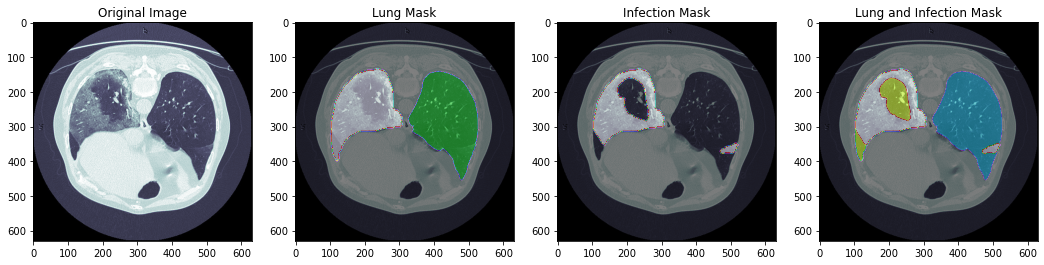

Text(0.5, 1.0, 'Lung and Infection Mask')

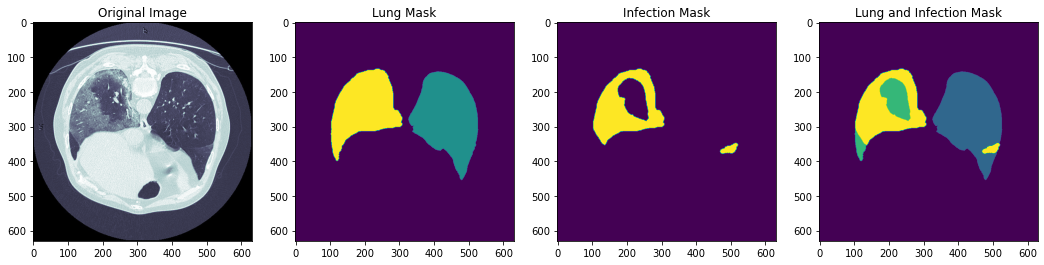

In [6]:
n =sample_all.shape[2] % 2
n = 33
fig = plt.figure(figsize = (18,15))
plt.subplot(1,4,1)
plt.imshow(sample_ct[..., n], cmap = 'bone')
plt.title('Original Image')
plt.subplot(1,4,2)
plt.imshow(sample_ct[..., n], cmap = 'bone')
plt.imshow(sample_lung[..., n],alpha = 0.5, cmap = 'nipy_spectral')
plt.title('Lung Mask')
plt.subplot(1,4,3)
plt.imshow(sample_ct[..., n], cmap = 'bone')
plt.imshow(sample_infe[..., n], alpha = 0.5, cmap = 'nipy_spectral')
plt.title('Infection Mask')
plt.subplot(1,4,4)
plt.imshow(sample_ct[..., n], cmap = 'bone')
plt.imshow(sample_all[..., n], alpha = 0.5, cmap = 'nipy_spectral')
plt.title('Lung and Infection Mask')
plt.show()
fig = plt.figure(figsize = (18,15))
plt.subplot(1,4,1)
plt.imshow(sample_ct[..., n], cmap = 'bone')
plt.title('Original Image')
plt.subplot(1,4,2)
plt.imshow(sample_lung[..., n])
plt.title('Lung Mask')
plt.subplot(1,4,3)
plt.imshow(sample_infe[..., n])
plt.title('Infection Mask')
plt.subplot(1,4,4)
plt.imshow(sample_all[..., n])
plt.title('Lung and Infection Mask')

In [7]:
im_size = sample_ct[:,:,1].shape

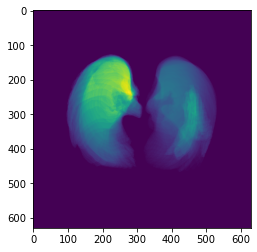

[128  96] [468 531]
2 (109511,) (109511,)


In [8]:
dd = sample_all[:,:,:].sum(axis=2)
plt.imshow(dd/sample_all.shape[2])
plt.show()
d_size_interes = np.where(dd > 0)
print(np.min(d_size_interes,axis=1),np.max(d_size_interes,axis=1))
print(len(d_size_interes),d_size_interes[0].shape,d_size_interes[1].shape)

In [9]:
[np.min(d_size_interes,axis=1),np.max(d_size_interes,axis=1)]

[array([128,  96]), array([468, 531])]

In [10]:
set(sample_all[:,:,n].reshape((im_size[0]*im_size[1])).tolist())

{0.0, 1.0, 2.0, 3.0}

In [11]:
set(sample_infe[:,:,n].reshape((im_size[0]*im_size[1])).tolist())

{0.0, 1.0}

In [12]:
from tensorflow.keras.utils import Sequence
class DataSequence(Sequence):
    """
    Keras Sequence object to train a model on a list of csv files
    """
    def __init__(self, data, batch_size=2,w_size = 256, mode='train'):
        """
        df = dataframe with two columns: the labels and a list of filenames
        """
        
        self.bsz = batch_size
        self.mode = mode
        self.ind = np.arange(batch_size)
        
        # Take labels and a list of image locations in memory
        self.data = data
        self.x1 = 0
        self.x2 = w_size
        self.y1 = 0
        self.y2 = w_size
        self.w = w_size
        
    def __len__(self):
        return int(math.ceil((self.data.shape[0]) / float(self.bsz)))

    def on_epoch_end(self):
        #print('epoch end:')
        self.indexes = range(self.data.shape[0])
        if self.mode == 'train':
            # Shuffles indexes after each epoch if in training mode
            self.indexes = np.random.choice(self.indexes, size=len(self.indexes))
            #print('gen end:')
  
    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        #idx * self.bsz: (idx + 1) * self.bsz
       
        imag = read_nii(data.loc[idx,'lung_and_infection_mask'])
        batch =[]
        
        d_size_interes = np.where(imag.sum(axis=2) > 0)
        xy_min = np.min(d_size_interes,axis=1)
        xy_max = np.max(d_size_interes,axis=1)
        self.x1 = xy_min[1]
        self.x2 = self.w + xy_min[1]
        self.y1 = xy_min[0]
        self.y2 = self.w + xy_min[0]
        
        for i in range(imag.shape[2]):
            
            imag4 = np.zeros((imag.shape[0],imag.shape[1],2))

            imag4[:,:,0] = imag[:,:,i]==1 
            imag4[:,:,0] = imag[:,:,i]==2 
            imag4[:,:,1] = imag[:,:,i]==3
            
            batch.append(imag4[self.y1:self.y2,self.x1:self.x2,:])
        self.ind = np.random.choice(np.arange(len(batch)), size=self.bsz )
        #print(type(self.ind))
        self.segment = np.array(batch)[self.ind].astype(float)    
        return self.segment
    def get_batch_features(self, idx):
        # Fetch a batch of inputs
        imag = read_nii(data.loc[idx,'ct_scan'])
        imag = imag.transpose([2,0,1])
        imag = imag / np.max(imag)
        imag =imag.reshape(imag.shape[0],imag.shape[1],imag.shape[2],1)
        return imag[self.ind,self.y1:self.y2,self.x1:self.x2,:]

    def __getitem__(self, idx):
        
        batch_y = self.get_batch_labels(idx)
        batch_x = self.get_batch_features(idx)
        return batch_x, batch_y
    
    
class DataSequence_infect(Sequence):

    """
    Keras Sequence object to train a model on a list of csv files
    """
    def __init__(self, data, batch_size=2,w_size = 256, mode='train'):
        """
        df = dataframe with two columns: the labels and a list of filenames
        """
        
        self.bsz = batch_size
        self.mode = mode
        self.ind = np.arange(batch_size)
        
        # Take labels and a list of image locations in memory
        self.data = data
        self.x1 = 0
        self.x2 = w_size
        self.y1 = 0
        self.y2 = w_size
        self.w = w_size
        

    def __len__(self):
        return int(math.ceil((self.data.shape[0]) / float(self.bsz)))

    def on_epoch_end(self):
        #print('epoch end:')
        self.indexes = range(self.data.shape[0])
        if self.mode == 'train':
            # Shuffles indexes after each epoch if in training mode
            self.indexes = np.random.choice(self.indexes, size=len(self.indexes))
            #print('gen end:')
          

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        #idx * self.bsz: (idx + 1) * self.bsz
       
        imag = read_nii(data.loc[idx,'lung_and_infection_mask'])
        batch =[]
        
        d_size_interes = np.where(imag.sum(axis=2) > 0)
        xy_min = np.min(d_size_interes,axis=1)
        xy_max = np.max(d_size_interes,axis=1)
        self.x1 = xy_min[1]
        self.x2 = self.w + xy_min[1]
        self.y1 = xy_min[0]
        self.y2 = self.w + xy_min[0]
        
        for i in range(imag.shape[2]):
            
            imag4 = np.zeros((imag.shape[0],imag.shape[1],1))


            imag4[:,:,0] = imag[:,:,i]==3
            
            batch.append(imag4[self.y1:self.y2,self.x1:self.x2,:])
        self.ind = np.random.choice(np.arange(len(batch)), size=self.bsz )
        #print(type(self.ind))
        self.segment = np.array(batch)[self.ind].astype(float)    
        return self.segment

    def get_batch_features(self, idx):
        # Fetch a batch of inputs
        imag = read_nii(data.loc[idx,'ct_scan'])
        imag = imag.transpose([2,0,1])
        imag = imag / np.max(imag)
        imag =imag.reshape(imag.shape[0],imag.shape[1],imag.shape[2],1)
        return imag[self.ind,self.y1:self.y2,self.x1:self.x2,:]

    def __getitem__(self, idx):
        
        batch_y = self.get_batch_labels(idx)
        batch_x = self.get_batch_features(idx)
        return batch_x, batch_y  

In [13]:
data_seq = DataSequence_infect(data.iloc[:-2,:],40)
data_seq_test = DataSequence_infect(data.iloc[-2:,:],40)
for i in range(2):
    x,y = data_seq_test[i]
    print(i,':',x.shape,y.shape)


0 : (40, 256, 256, 1) (40, 256, 256, 1)
1 : (40, 256, 256, 1) (40, 256, 256, 1)


In [14]:
data_seq_2 = DataSequence(data.iloc[:-2,:],10)
data_seq_test_2 = DataSequence(data.iloc[-2:,:],10)
for i in range(2):
    x2,y2 = data_seq_2[i]
    print(i,':',x2.shape,y2.shape)

0 : (10, 256, 256, 1) (10, 256, 256, 2)
1 : (10, 256, 256, 1) (10, 256, 256, 2)


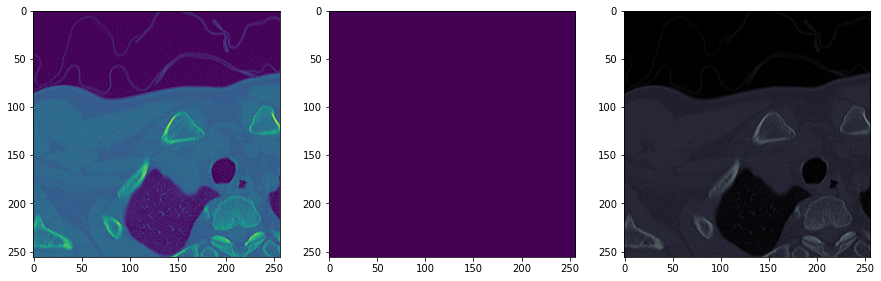

In [15]:
n = 16
fig = plt.figure(figsize = (15,5))
plt.subplot(1,3,1)
plt.imshow(x[n,:,:,0])
plt.subplot(1,3,2)
plt.imshow(y[n,:,:,0])
plt.subplot(1,3,3)
plt.imshow(x[n,:,:,0], cmap = 'bone')
plt.imshow(y[n,:,:,0], alpha = 0.5, cmap = 'nipy_spectral')

plt.show()

In [16]:
np.max(x)

0.22431274171631652

In [17]:
def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)


def focal(y_true, y_pred):
    alpha = 1
    gamma = 2
    
    num = y_true.shape
    print(y_true,y_pred)

    
    y_pred = ops.convert_to_tensor_v2_with_dispatch(y_pred)
    y_true = math_ops.cast(y_true, y_pred.dtype)
    BCE_loss = tensorflow.keras.losses.CategoricalCrossentropy()

    return K.mean((y_pred - 1)** gamma * alpha * BCE_loss( y_true, y_pred), axis=-1)
   



def mae(y_true, y_pred):
    true_value = K.sum(y_true * K.arange(0, 100, dtype="float32"), axis=-1)
    pred_value = K.sum(y_pred * K.arange(0, 100, dtype="float32"), axis=-1)
    mae = K.mean(K.abs(true_value - pred_value))
    return mae

In [18]:
def unet_pre_train(num_classes = 13, input_shape= (200, 200, 3),level = 3,neuron = 18, lr=0.0001,b1 = 0.9, b2=0.9999):  

    img_input = Input(shape = input_shape)
    x = img_input
    print(x)
    
    blocks_ = []
    i = 0
    for i in range(level+1):
        x = Conv2D(neuron*(i+1), (3, 3), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = Conv2D(neuron*(i+1), (3, 3), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x) 
        blocks4 = x
        blocks_.append(x)
        print('i: ',i,x)
    
        # down i
        x = MaxPooling2D(padding='same')(x)
    
     
   
    x = Conv2D(neuron*(level+1), (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(neuron*(level+1), (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # задаем список скипов
    print(blocks_)
    print(x)

    for i in range(level,0,-1):
      # UP i
      print(i)
      x = Conv2DTranspose(neuron*i, (2, 2), strides=(2, 2), padding='same')(x)
      x = BatchNormalization()(x)
      x = Activation('relu')(x)
        
      x = concatenate([x, blocks_[i]] ) # добавили перенос из понижаюшего плеча 
      x = Conv2D(neuron*i, (3, 3), padding='same')(x)
      x = BatchNormalization()(x)
      x = Activation('relu')(x)

      x = Conv2D(neuron*i, (3, 3), padding='same')(x)
      x = BatchNormalization()(x)
      x = Activation('relu')(x)


    print(x)
    x = Conv2DTranspose(neuron*i, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
        
    x = concatenate([x, blocks_[0]] ) # добавили перенос из понижаюшего плеча 
    # последний слой сверток для классификации
    x = Conv2D(neuron, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    if num_classes>1:
      x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)
      # собираем модель 
      model = Model(img_input, x)
      model.compile(optimizer=Adam(),
                    loss= 'categorical_crossentropy',#focal, #'
                    metrics=[dice_coef])
    else:
      x = Conv2D(num_classes, (3, 3), activation='sigmoid', padding='same')(x)
      # собираем модель 
      model = Model(img_input, x)
      model.compile(optimizer=Adam(learning_rate=lr, beta_1=b1, beta_2=b2),
                    loss = 'mse',
                    metrics=[dice_coef])

    model.summary()
    # вернем модель
    return model

In [19]:
im_size=x[0,:,:,:].shape
model= unet_pre_train(num_classes = 1, input_shape= (im_size[0], im_size[1], im_size[2]), level = 3,neuron = 65)

KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
i:  0 KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 65), dtype=tf.float32, name=None), name='activation_1/Relu:0', description="created by layer 'activation_1'")
i:  1 KerasTensor(type_spec=TensorSpec(shape=(None, 128, 128, 130), dtype=tf.float32, name=None), name='activation_3/Relu:0', description="created by layer 'activation_3'")
i:  2 KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 195), dtype=tf.float32, name=None), name='activation_5/Relu:0', description="created by layer 'activation_5'")
i:  3 KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 260), dtype=tf.float32, name=None), name='activation_7/Relu:0', description="created by layer 'activation_7'")
[<KerasTensor: shape=(None, 256, 256, 65) dtype=float32 (created by layer 'activation_1')>, <KerasTensor: shape=(None, 128, 128, 130) dtype=float32 (created by 

In [20]:
es = EarlyStopping(monitor = ['val_loss'], patience = 3)
modch = ModelCheckpoint(monitor='val_loss',mode='min',save_best_only=True,save_weights_only=True,verbose=1,filepath='model.{epoch:02d}-{val_loss:.2f}.h5')

In [21]:
COVID = model.fit_generator(data_seq, epochs=170, verbose=1,validation_data = data_seq_test) # , callbacks =[es,modch]

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/170
1/1 [==============================] - 19s 19s/step - loss: 0.2783 - dice_coef: 0.0551 - val_loss: 0.2505 - val_dice_coef: 0.0587
Epoch 2/170
1/1 [==============================] - 5s 5s/step - loss: 0.2506 - dice_coef: 0.0552 - val_loss: 0.2495 - val_dice_coef: 0.0526
Epoch 3/170
1/1 [==============================] - 5s 5s/step - loss: 0.2364 - dice_coef: 0.0684 - val_loss: 0.2486 - val_dice_coef: 0.0675
Epoch 4/170
1/1 [==============================] - 4s 4s/step - loss: 0.2165 - dice_coef: 0.0751 - val_loss: 0.2473 - val_dice_coef: 0.0357
Epoch 5/170
1/1 [==============================] - 5s 5s/step - loss: 0.1996 - dice_coef: 0.0435 - val_loss: 0.2458 - val_dice_coef: 0.0474
Epoch 6/170
1/1 [==============================] - 5s 5s/step - loss: 0.1901 - dice_coef: 0.0679 - val_loss: 0.2446 - val_dice_coef: 0.0438
Epoch 7/170
1/1 [==============================] - 5s 5s/step - loss: 0.1746 - dice_coef: 0.0382 - val_loss: 0.2432 - val_dice_coef: 0.0459
Epoch 8/170
1/1 [=

1/1 [==============================] - 5s 5s/step - loss: 0.0279 - dice_coef: 0.1384 - val_loss: 0.1786 - val_dice_coef: 0.0501
Epoch 60/170
1/1 [==============================] - 5s 5s/step - loss: 0.0297 - dice_coef: 0.0893 - val_loss: 0.1780 - val_dice_coef: 0.0614
Epoch 61/170
1/1 [==============================] - 5s 5s/step - loss: 0.0291 - dice_coef: 0.1613 - val_loss: 0.1786 - val_dice_coef: 0.0507
Epoch 62/170
1/1 [==============================] - 5s 5s/step - loss: 0.0266 - dice_coef: 0.1265 - val_loss: 0.1748 - val_dice_coef: 0.0399
Epoch 63/170
1/1 [==============================] - 5s 5s/step - loss: 0.0279 - dice_coef: 0.1142 - val_loss: 0.1775 - val_dice_coef: 0.0826
Epoch 64/170
1/1 [==============================] - 5s 5s/step - loss: 0.0366 - dice_coef: 0.1912 - val_loss: 0.1763 - val_dice_coef: 0.0605
Epoch 65/170
1/1 [==============================] - 5s 5s/step - loss: 0.0268 - dice_coef: 0.1739 - val_loss: 0.1756 - val_dice_coef: 0.0705
Epoch 66/170
1/1 [========

1/1 [==============================] - 4s 4s/step - loss: 0.0138 - dice_coef: 0.3810 - val_loss: 0.1187 - val_dice_coef: 0.0579
Epoch 118/170
1/1 [==============================] - 5s 5s/step - loss: 0.0140 - dice_coef: 0.3318 - val_loss: 0.1225 - val_dice_coef: 0.0822
Epoch 119/170
1/1 [==============================] - 5s 5s/step - loss: 0.0163 - dice_coef: 0.3257 - val_loss: 0.1177 - val_dice_coef: 0.0523
Epoch 120/170
1/1 [==============================] - 5s 5s/step - loss: 0.0169 - dice_coef: 0.3844 - val_loss: 0.1271 - val_dice_coef: 0.0771
Epoch 121/170
1/1 [==============================] - 5s 5s/step - loss: 0.0126 - dice_coef: 0.3415 - val_loss: 0.1116 - val_dice_coef: 0.0453
Epoch 122/170
1/1 [==============================] - 5s 5s/step - loss: 0.0131 - dice_coef: 0.3771 - val_loss: 0.1202 - val_dice_coef: 0.0767
Epoch 123/170
1/1 [==============================] - 5s 5s/step - loss: 0.0137 - dice_coef: 0.3936 - val_loss: 0.1169 - val_dice_coef: 0.0562
Epoch 124/170
1/1 [=

In [25]:
model.save_weights('model.hdf5')

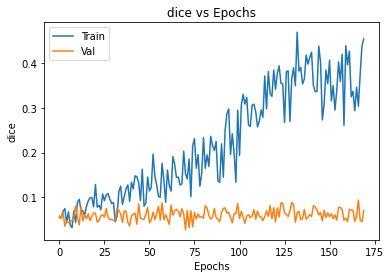

In [27]:
plt.plot(COVID.history['dice_coef'])
plt.plot(COVID.history['val_dice_coef'])
plt.title('dice vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('dice')
plt.legend(['Train', 'Val'], loc = 'upper left')
plt.show()

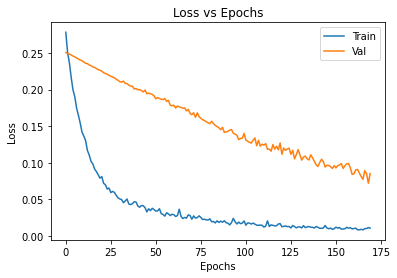

In [28]:
plt.plot(COVID.history['loss'])
plt.plot(COVID.history['val_loss'])
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc = 'upper right')
plt.show()

In [29]:
X,Y = data_seq[0]
Xt,Yt = data_seq_test[0]

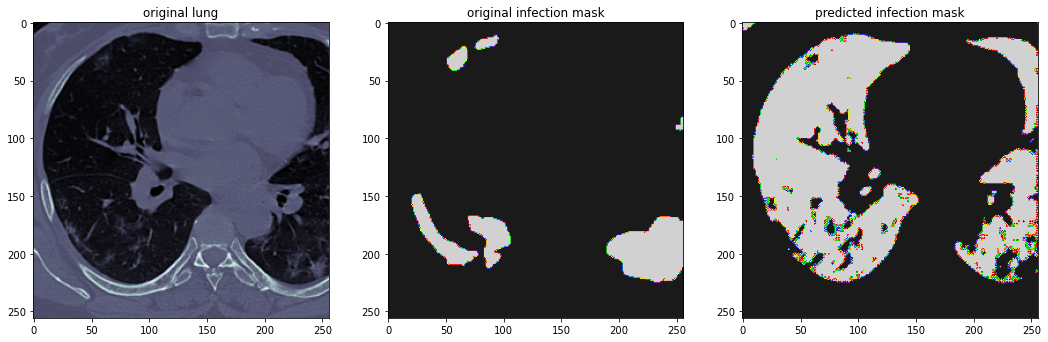

In [30]:
predictedt = model.predict(Xt)
n = 16
chanel = 0
fig = plt.figure(figsize = (18,15))
plt.subplot(1,3,1)
plt.imshow(Xt[n][...,0], cmap = 'bone')
plt.title('original lung')
plt.subplot(1,3,2)
#plt.imshow(Xt[n][...,0], cmap = 'bone')
plt.imshow(Yt[n][...,chanel],alpha = 0.9, cmap = "nipy_spectral")
plt.title('original infection mask')
plt.subplot(1,3,3)
#plt.imshow(Xt[n][...,0], cmap = 'bone')
plt.imshow((predictedt[n,:,:,chanel]>predictedt[n,:,:,chanel].mean()*1.25).astype(float),alpha = 0.9,cmap = "nipy_spectral")
plt.title('predicted infection mask')
plt.show()

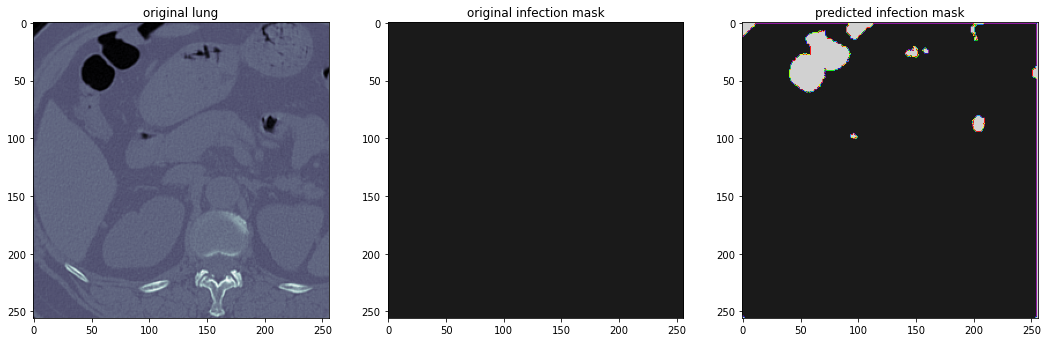

In [31]:
predicted = model.predict(X)
n = 16
chanel = 0
fig = plt.figure(figsize = (18,15))

plt.subplot(1,3,1)
plt.imshow(X[n][...,0], cmap = 'bone')
plt.title('original lung')

plt.subplot(1,3,2)
#plt.imshow(X[n][...,0], cmap = 'bone')
plt.imshow(Y[n][...,chanel],alpha = 0.9, cmap = "nipy_spectral")
plt.title('original infection mask')

plt.subplot(1,3,3)
#plt.imshow(X[n][...,0], cmap = 'bone')
plt.imshow((predicted[n,:,:,chanel]>predicted[n,:,:,chanel].mean()*1.25).astype(float),alpha = 0.9,cmap = "nipy_spectral")
plt.title('predicted infection mask')
plt.show()

In [39]:
predictedt.shape

(40, 256, 256, 1)

In [45]:
#y_pred_final = model.predict(Xt)
#data['**********'] = y_pred_final
#data.to_csv('pred.csv', index=False)
#pdata.head(10)